In [6]:
import pandas as pd
from datetime import datetime, time
import numpy as np

ES_df = pd.read_csv('./data/ES_5Years_8_11_2024.csv')
NQ_df = pd.read_csv('./data/NQ_5Years_8_11_2024.csv')
ES_df['datetime'] = pd.to_datetime(ES_df['Time'])
NQ_df['datetime'] = pd.to_datetime(NQ_df['Time'])

ES_df['Date'] = ES_df['datetime'].dt.date
ES_df['Time'] = ES_df['datetime'].dt.time
NQ_df['Date'] = NQ_df['datetime'].dt.date
NQ_df['Time'] = NQ_df['datetime'].dt.time

ES_df['datetime'] = ES_df['datetime'].dt.round('min')
NQ_df['datetime'] = NQ_df['datetime'].dt.round('min')
ES_df = ES_df.set_index('datetime')
NQ_df = NQ_df.set_index('datetime')

display(ES_df)
print(ES_df.dtypes)

,Time,Open,High,Low,Close,Volume,Date
datetime,,,,,,,
2019-08-11 18:05:00,18:05:00,3201.50,3209.25,3201.50,3207.75,3407,2019-08-11
2019-08-11 18:10:00,18:10:00,3207.50,3208.50,3206.75,3207.50,821,2019-08-11
2019-08-11 18:15:00,18:15:00,3207.50,3208.00,3205.50,3206.00,589,2019-08-11
2019-08-11 18:20:00,18:20:00,3205.75,3206.00,3204.75,3205.00,329,2019-08-11
2019-08-11 18:25:00,18:25:00,3205.00,3206.00,3203.25,3204.25,1025,2019-08-11
...,...,...,...,...,...,...,...
2024-08-09 16:35:00,16:35:00,5365.75,5366.50,5365.25,5365.75,1195,2024-08-09
2024-08-09 16:40:00,16:40:00,5365.50,5365.75,5364.75,5365.00,506,2024-08-09
2024-08-09 16:45:00,16:45:00,5365.00,5365.00,5364.25,5364.50,512,2024-08-09


Time       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Date       object
dtype: object


In [2]:
def generate_trade_data(df, dates, time_start, time_end):
    rows = []

    for date_str in dates:
        date_obj = pd.to_datetime(date_str).date()
        start_dt = pd.Timestamp(datetime.combine(date_obj, time_start)).round('min')
        end_dt = pd.Timestamp(datetime.combine(date_obj, time_end)).round('min')

        if start_dt in df.index and end_dt in df.index:
            start_price = df.loc[start_dt]['Close']
            end_price = df.loc[end_dt]['Close']
            diff = end_price - start_price

            rows.append({
                'date': date_str,
                'start_dt': start_dt,
                'end_dt': end_dt,
                'start_price': start_price,
                'end_price': end_price,
                'diff': diff
            })

    return pd.DataFrame(rows)

def backtest(trade_df, position='long'):
    if position == 'long':
        trade_df['PnL'] = trade_df['diff']
    elif position == 'short':
        trade_df['PnL'] = -trade_df['diff']
    else:
        raise ValueError("Position must be 'long' or 'short'")

    trade_df['cumulative_PnL'] = trade_df['PnL'].cumsum()
    return trade_df

dates = ['2023-11-30', '2024-02-29', '2024-05-31']
time_start = time(15, 30)
time_end = time(15, 55)

trade_df = generate_trade_data(ES_df, dates, time_start, time_end)
bt_result = backtest(trade_df, position='long')
display(bt_result)

,date,start_dt,end_dt,start_price,end_price,diff,PnL,cumulative_PnL
0,2023-11-30,2023-11-30 15:30:00,2023-11-30 15:55:00,4734.25,4754.25,20.0,20.0,20.0
1,2024-02-29,2024-02-29 15:30:00,2024-02-29 15:55:00,5227.25,5234.75,7.5,7.5,27.5
2,2024-05-31,2024-05-31 15:30:00,2024-05-31 15:55:00,5309.50,5345.50,36.0,36.0,63.5


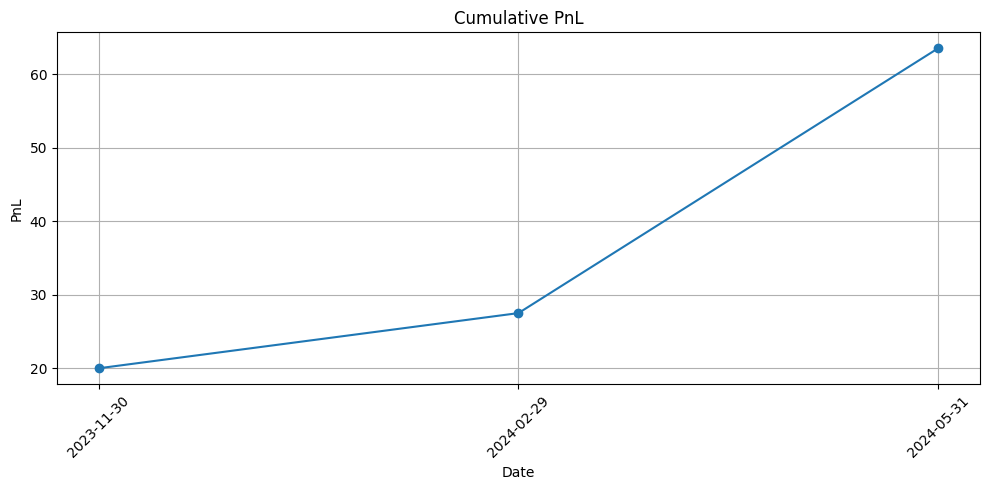

In [3]:
import matplotlib.pyplot as plt

def plot_pnl(trade_df):
    plt.figure(figsize=(10, 5))
    plt.plot(trade_df['date'], trade_df['cumulative_PnL'], marker='o')
    plt.title('Cumulative PnL')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_pnl(bt_result)

In [7]:
def calculate_annualized_sharpe(trade_df):
    start = pd.to_datetime(trade_df['date'].min())
    end = pd.to_datetime(trade_df['date'].max())
    num_business_days = np.busday_count(start.date(), end.date()) or 1  # prevent divide-by-zero

    mean_pnl = trade_df['PnL'].mean()
    std_pnl = trade_df['PnL'].std(ddof=0)

    if std_pnl == 0:
        sharpe = np.nan
    else:
        sharpe = (mean_pnl / std_pnl) * np.sqrt(252 / num_business_days)

    print(f"Annualized Sharpe Ratio: {sharpe:.4f}")
    return sharpe

calculate_annualized_sharpe(bt_result)

Annualized Sharpe Ratio: 2.5169


np.float64(2.5168593884619654)